# Homework5 -  OAS Model Part I

NetID: sg7993

Name: James Guan

In [1]:
import numpy as np
import pandas as pd
from typing import Optional, List, Dict
import matplotlib.pyplot as plt


Load forward simulation data that was provided in the assignment

In [2]:
# rotate index and columns
forward_rate_paths = pd.read_csv('data/hw5_forward_paths.csv', index_col=0).T/100
forward_rate_paths.shape

(360, 500)

In [3]:
forward_rate_paths.iloc[0:5, 0:5]

path,1,2,3,4,5
0,0.001700,0.001700,0.001700,0.001700,0.001700
1,0.002078,0.001683,0.001519,0.002242,0.001752
2,0.002465,0.001633,0.001285,0.002813,0.001777
3,0.002823,0.001568,0.001044,0.003347,0.001786
4,0.003212,0.002101,0.001365,0.003963,0.002086


Basic information of the TBA

In [4]:
current_loan_balance = 405_903_000_000
original_loan_balance = 518_318_000_000
factor = current_loan_balance / original_loan_balance # 0.783115983
c = 0.04070
fee = c - 0.035
og_maturity = 360
WALA = 29 # 360 - 331
print("Current Loan Balance:", current_loan_balance
      , "\nOriginal Loan Balance:", original_loan_balance
      , "\nFactor:", factor
      , "\nWAC:", c
      , "\nServicing Fee:", round(fee,4)
      , "\nOriginal Maturity:", og_maturity
      , "\nWALA:", WALA)

Current Loan Balance: 405903000000 
Original Loan Balance: 518318000000 
Factor: 0.7831157706272983 
WAC: 0.0407 
Servicing Fee: 0.0057 
Original Maturity: 360 
WALA: 29


Let us demonstrate the methodology to calculate 10-yr at-market swap rate. 

In [5]:
test_path = forward_rate_paths.iloc[:,0].values
print("Test forward rate shape:", test_path.shape)
test_path[:5]

Test forward rate shape: (360,)


array([0.0017    , 0.00207781, 0.00246529, 0.00282341, 0.00321245])

In [6]:
rates_10yr = test_path[0:120]
print("10-yr forward rate shape:", rates_10yr.shape)

10-yr forward rate shape: (120,)


In [7]:
def calculate_discount_factors(rates):
    d = 1
    dfs = []
    for r in rates:
        d = d / (1 + r/12)
        dfs.append(d)
    return dfs

In [8]:
rates_10yr[:5]

array([0.0017    , 0.00207781, 0.00246529, 0.00282341, 0.00321245])

In [9]:
dfs = calculate_discount_factors(rates_10yr)
dfs[:5], type(dfs)

([0.999858353399935,
  0.9996852571620557,
  0.9994799230971279,
  0.9992448169286757,
  0.9989773866871824],
 list)

In [10]:
def calculate_swap_rate(discount_factors: list):
    sr = 12 * (1 - discount_factors[-1]) / sum(discount_factors)
    return sr

In [11]:
calculate_swap_rate(dfs)

0.05751145314889102

Now let us put the above code into the forward yield curve class

In [12]:
class ForwardYieldCurve:    
    def __init__(self, rate_data: np.array, **kwargs):
        self._spread = kwargs.get('spread', 0.0175)
        self._data = rate_data
        self._10yr_market_swap_rate: Optional[list] = None
        
    def calculate_swap_rate(self):
        self._10yr_market_swap_rate = []
        for i in range(len(self._data)):
            if i + 120 < len(self._data):
                _10yr_rates = self._data[i: i+120]
                dfs = self._calculate_discount_factors(_10yr_rates)
                sr = self._calculate_swap_rate(dfs)
                self._10yr_market_swap_rate.append(sr)
            else:
                prev = self._10yr_market_swap_rate[-1]
                self._10yr_market_swap_rate.append(prev)
    
    def get_swap_rate(self, i):
        if self._10yr_market_swap_rate is None:
            self.calculate_swap_rate()
        if i >= len(self._10yr_market_swap_rate):
            raise ValueError('No swap rate for the given period')
        return self._10yr_market_swap_rate[i]
    
    def get_forward_rate(self, i):
        if i >= len(self._data):
            raise ValueError('No forward rate for the given period')
        return self._data[i]
    
    def get_prevailing_mortgage_rate(self, i):
        if i >= len(self._data):
            raise ValueError('No mortgage rate for the given period')
        return self.get_swap_rate(i) + self._spread
    
    def shock(self, bps: float):
        self._data = self._data + bps/10000
    
    @staticmethod
    def _calculate_discount_factors(rates):
        d = 1
        dfs = []
        for r in rates:
            d = d / (1 + r/12)
            dfs.append(d)
        return dfs
    
    @staticmethod
    def _calculate_swap_rate(dfs: list) -> float:
        sr = 12 * (1 - dfs[-1]) / sum(dfs)
        return sr

In [13]:
test_rate_path = forward_rate_paths.iloc[:,0].values # numpy array
fyc = ForwardYieldCurve(test_rate_path)

In [14]:
fyc.calculate_swap_rate()
fyc.get_swap_rate(0)

0.05751145314889102

In [15]:
class SCurve:
    
    def __init__(self, data: Dict[float| int, float | int], **kwargs):
        self._method = kwargs.get('method', 'linear')
        self._data = data
        self._x = sorted(data.keys())
        self._y = [data[k] for k in self._x]
    
    def get_psa(self, x: float | int) -> float:
        # x = prevailing mortgage rate - mortgage rate (fixed in our case)
        if self._method == 'linear':
            return self._linear_psa(x)
        else:
            raise ValueError('Invalid method')
    
    def _linear_psa(self, bps: float | int) -> float:
        x = bps
        if x < self._x[0]:
            return self._y[0]
        if x > self._x[-1]:
            return self._y[-1]
        for i in range(1, len(self._x)):
            if x <= self._x[i]:
                return self._y[i-1] + (x - self._x[i-1]) * (self._y[i] - self._y[i-1]) / (self._x[i] - self._x[i-1])
        return self._y[-1]

In [16]:
diff = [-300, -200, -100, -50, 0 , 50, 100, 200, 300]
psa_speed = [1164, 998, 621, 371, 185, 145,117,90,83]
psa_data = dict(zip(diff, psa_speed))
scurve = SCurve(psa_data)

Verify the PSA curve (linear interpolation)

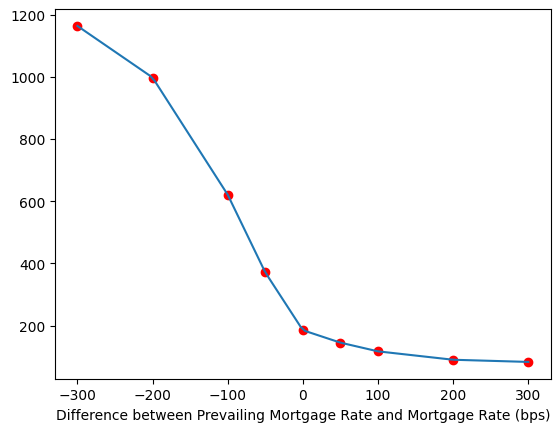

In [17]:
# Existing plot
x = np.linspace(-300, 300, 100)
y = [scurve.get_psa(i) for i in x]
plt.plot(x, y)

# Add scatter points
x_scatter = list(psa_data.keys())
y_scatter = list(psa_data.values())
plt.scatter(x_scatter, y_scatter, color='red')  # color is optional

plt.xlabel('Difference between Prevailing Mortgage Rate and Mortgage Rate (bps)')
plt.show()

In [18]:
class PSA: # TODO: optimization needed in the future
    
    def __init__(self, speed: float):
        self._speed = speed
        self.end_CPR = 0.06 * speed/100
        
    @property
    def speed(self):
        return self._speed
    
    def CPR(self, month_index: int):
        return min(self.end_CPR,  0.002 + (self.end_CPR - 0.002)/30 * month_index) 
    
    def SMM(self, month_index: int):
        return 1 - (1 - self.CPR(month_index))**(1/12)

In [19]:
from homework_utils.previous_homework_func import calcualte_monthly_payment
    
class MBS:
    def __init__(self, principal: float, wac: float,  og_maturity: int, og_principal: float, servicing_fee: float,  current_month: int, current_month_period: pd.Period | int):
        """
        MBS class that simulates the MBS cashflows given the parameters. Assumes all loans have the same Coupon rate as WAC and same maturity.
        Curtailments are assumed to be the only prepayments. (No prepayments)
        :param principal: current principal/loan balance
        :param wac:  Weighted Average Coupon rate
        :param og_maturity:  original maturity of the loan
        :param og_principal:  original principal of the loan
        :param servicing_fee:  servicing fee + guarantee fee
        :param current_month:  current time to maturity
        """
        self.principal = principal # current principal amount
        self.wac = wac
        self.og_maturity = og_maturity
        self.og_principal = og_principal
        self.servicing_fee = servicing_fee
        self.t = current_month # current month index
        self.t_period_index = current_month_period
        self.monthly_payment = calcualte_monthly_payment(self.og_principal, self.wac, self.og_maturity)
        self._ongoing = principal > 0        
        self._cashflows = {}
    
    def next_month_cash_flow(self, smm: float, **kwargs):
        """
        Calculate the cash flow for the next month given the SMM from time t to t+1.
        Cash flow includes total payment, interest, principal, servicing fee, scheduled principal, curtailment, net_cash_flow, net_interest_payment, etc
        :param smm: float 
        :return: dictionary of cash flows of each type
        """
        
        if not self._ongoing:
            raise ValueError('Loan has been paid off')
        
        prev_principal = self.principal
        interest_payment = self.principal * self.wac / 12
        scheduled_principal = self.monthly_payment - interest_payment
        
        if self.principal <= scheduled_principal:
            # last month of the loan (everyone pays off the loan)
            smm = 0 # no prepayments 
            self._ongoing = False
            scheduled_principal = self.principal        

        curtailment = (self.principal - scheduled_principal) * smm # scheduled balance * SMM
        total_payment =self.monthly_payment + curtailment
        principal_payment = scheduled_principal + curtailment
        net_interest_payment = interest_payment * (1 - self.servicing_fee/12)
        net_cash_flow = principal_payment + net_interest_payment
        self.principal -= principal_payment
        self.t += 1
        self.t_period_index += 1
        cashflow_record = {
            'month_index': self.t,
            'month_period': self.t_period_index,
            'total_payment': total_payment,
            'interest_payment': interest_payment,
            'principal_payment': principal_payment,
            'scheduled_principal': scheduled_principal,
            'net_interest_payment': net_interest_payment,
            'curtailment': curtailment,
            'net_cash_flow': net_cash_flow,
            'principal': self.principal,
            'SMM': smm,
            'prev_principal': prev_principal
        }
        # add whatever it is from kwargs to the cashflow_record
        for k, v in kwargs.items():
            cashflow_record[k] = v
    
        self._cashflows[self.t_period_index] = cashflow_record
        return cashflow_record
    
    def get_cashflows(self):
        return self._cashflows
    
    def has_next_month(self):
        return self._ongoing
    
    

## Simulation - One path simulation for the MBS

Let us simulate the MBS cashflows for the first path of the forward rate simulation data as for demonstration purposes.

In [20]:
mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= 0)

print("Current Principal:", mbs.principal)
print("Current WAC:", mbs.wac)
print("Original Maturity:", mbs.og_maturity)
print("Original Principal:", mbs.og_principal)
print("Servicing Fee:", mbs.servicing_fee)
print("Monthly Payment:", mbs.monthly_payment)
print("Current Month (where 0 means the month of initiation):", mbs.t)
print("Current Period (where 0 means current time):", mbs.t_period_index)
print("-------------------------------")
rate_path1 = forward_rate_paths.iloc[:,0].values
fyc = ForwardYieldCurve(rate_path1)
c = mbs.wac # mortgage rate
scurve = SCurve(psa_data)
for month_index in range(1, 2):
    cur_r = fyc.get_prevailing_mortgage_rate(month_index) # prevailing mortgage rate
    x = (cur_r - c) * 10000 # in bps
    psa = PSA(scurve.get_psa(x))
    smm = psa.SMM(month_index + WALA)
    cashflow = mbs.next_month_cash_flow(smm, psa=psa.speed, x= x)
    print(cashflow)
    print("Current Month:", month_index + WALA, mbs.t)
    print("SMM:", smm)
    print("PSA:", psa.speed)

Current Principal: 405903000000
Current WAC: 0.0407
Original Maturity: 360
Original Principal: 518318000000
Servicing Fee: 0.005699999999999997
Monthly Payment: 2495492211.5764728
Current Month (where 0 means the month of initiation): 29
Current Period (where 0 means current time): 0
-------------------------------
{'month_index': 30, 'month_period': 1, 'total_payment': 4214955336.512455, 'interest_payment': 1376687675.0, 'principal_payment': 2838267661.512455, 'scheduled_principal': 1118804536.5764728, 'net_interest_payment': 1376033748.354375, 'curtailment': 1719463124.935982, 'net_cash_flow': 4214301409.86683, 'principal': 403064732338.48755, 'SMM': 0.00424785143344697, 'prev_principal': 405903000000, 'psa': 83, 'x': 352.0081416879643}
Current Month: 30 30
SMM: 0.00424785143344697
PSA: 83


Notice: month_index is the month index where 0 means the initial month and month_period means the current time period where 0 means the current time period.

In [21]:
mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= 0)

fyc = ForwardYieldCurve(rate_path1)
c = mbs.wac # mortgage rate
scurve = SCurve(psa_data)
month_index = 1
while mbs.has_next_month():
    sr = fyc.get_swap_rate(month_index)
    cur_r = fyc.get_prevailing_mortgage_rate(month_index) # prevailing mortgage rate
    x = cur_r - c
    x_bps = (cur_r - c)*10000 # in bps
    psa_speed = scurve.get_psa(x_bps)
    psa = PSA(psa_speed)
    smm = psa.SMM(month_index + WALA)
    mbs.next_month_cash_flow(smm, psa=psa.speed, Scurve_x = x, swap_rate = sr, prevailing_mortgage_rate = cur_r, cpr = psa.CPR(month_index + WALA))
    month_index += 1

Text(0.5, 0, 'Month Index')

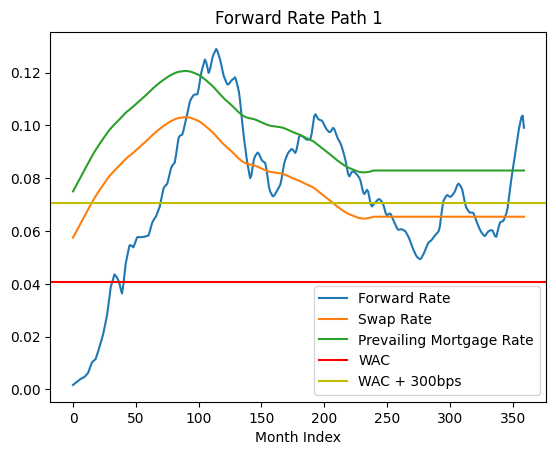

In [22]:
# plot rate_path1
plt.plot(rate_path1, label='Forward Rate')
plt.plot([fyc.get_swap_rate(i) for i in range(len(rate_path1))], label='Swap Rate')
plt.plot([fyc.get_prevailing_mortgage_rate(i) for i in range(len(rate_path1))], label='Prevailing Mortgage Rate')
# plot horizontal line at WAC
plt.axhline(y=c, color='r', linestyle='-', label='WAC')
plt.axhline(y=c+0.03, color='y', linestyle='-', label='WAC + 300bps')
plt.title('Forward Rate Path 1')
plt.legend()
plt.xlabel('Month Index')

In [23]:
cashflows_record = mbs.get_cashflows()

In [24]:
cashflows_df = pd.DataFrame(cashflows_record).T

In [25]:
cashflows_df = cashflows_df.rename(columns={'month_index': 'WALA', 'month_period': 'Month Index (Timeline)' })

In [26]:
cashflows_df

,WALA,Month Index (Timeline),total_payment,interest_payment,principal_payment,scheduled_principal,net_interest_payment,curtailment,net_cash_flow,principal,SMM,prev_principal,psa,Scurve_x,swap_rate,prevailing_mortgage_rate,cpr
1,30.0,1.0,4.214955e+09,1.376688e+09,2.838268e+09,1.118805e+09,1.376034e+09,1.719463e+09,4.214301e+09,4.030647e+11,0.004248,4.059030e+11,83.0,0.035201,0.058401,0.075901,0.0498
2,31.0,2.0,4.202858e+09,1.367061e+09,2.835797e+09,1.128431e+09,1.366412e+09,1.707366e+09,4.202209e+09,4.002289e+11,0.004248,4.030647e+11,83.0,0.036086,0.059286,0.076786,0.0498
3,32.0,3.0,4.190771e+09,1.357443e+09,2.833328e+09,1.138049e+09,1.356798e+09,1.695279e+09,4.190126e+09,3.973956e+11,0.004248,4.002289e+11,83.0,0.036966,0.060166,0.077666,0.0498
4,33.0,4.0,4.178695e+09,1.347833e+09,2.830861e+09,1.147659e+09,1.347193e+09,1.683202e+09,4.178054e+09,3.945647e+11,0.004248,3.973956e+11,83.0,0.037844,0.061044,0.078544,0.0498
5,34.0,5.0,4.166629e+09,1.338232e+09,2.828397e+09,1.157260e+09,1.337596e+09,1.671137e+09,4.165993e+09,3.917363e+11,0.004248,3.945647e+11,83.0,0.038725,0.061925,0.079425,0.0498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,178.0,149.0,2.534397e+09,3.939370e+07,2.495004e+09,2.456099e+09,3.937499e+07,3.890501e+07,2.534379e+09,9.119846e+09,0.004248,1.161485e+10,83.0,0.060720,0.083920,0.101420,0.0498
150,179.0,150.0,2.523763e+09,3.093148e+07,2.492831e+09,2.464561e+09,3.091679e+07,2.827066e+07,2.523748e+09,6.627015e+09,0.004248,9.119846e+09,83.0,0.060509,0.083709,0.101209,0.0498
151,180.0,151.0,2.513138e+09,2.247663e+07,2.490661e+09,2.473016e+09,2.246595e+07,1.764557e+07,2.513127e+09,4.136354e+09,0.004248,6.627015e+09,83.0,0.060302,0.083502,0.101002,0.0498
152,181.0,152.0,2.502522e+09,1.402913e+07,2.488493e+09,2.481463e+09,1.402247e+07,7.029729e+06,2.502515e+09,1.647861e+09,0.004248,4.136354e+09,83.0,0.060096,0.083296,0.100796,0.0498


<Axes: title={'center': 'Net Cash Flow vs. Month Index'}, xlabel='Month Index (Timeline)'>

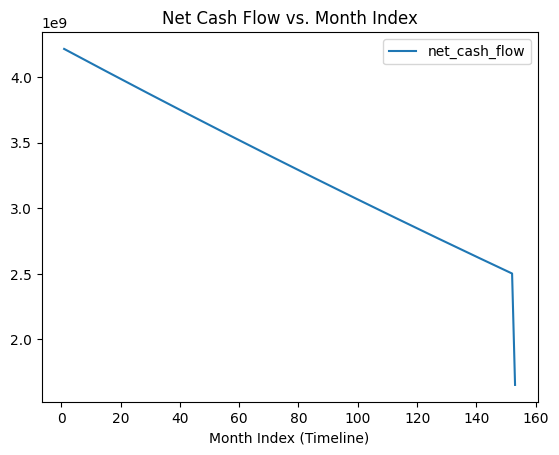

In [27]:
cashflows_df.plot(x='Month Index (Timeline)', y='net_cash_flow', title='Net Cash Flow vs. Month Index')

<Axes: title={'center': 'Scurve(X) vs. Month Index'}, xlabel='Month Index'>

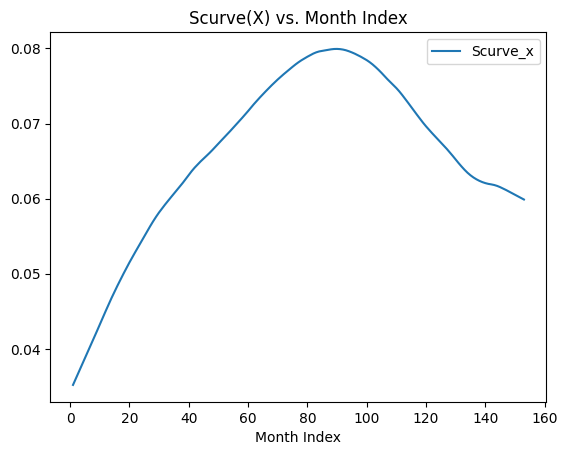

In [28]:
cashflows_df[['Scurve_x']].plot(title='Scurve(X) vs. Month Index', xlabel='Month Index')

OAS solver class

In [29]:
cashflows = {k: v['net_cash_flow'] for k,v in cashflows_record.items()}

In [30]:
result = {}
temp_dict = {}
temp_dict['rate_data'] = rate_path1
temp_dict['cashflows'] = cashflows
result['SIM1'] = temp_dict

In [31]:
def calculate_mbs_price(cashflows: dict, yield_curve: ForwardYieldCurve, oas: float, verbose = False):
        """
        Calculate the MBS price given the cash flows, yield curve, and OAS
        :param cash_flow_dict: dictionary of cash flows for each SIMULATION
        :param yield_curve: YieldCurve object
        :param oas: OAS
        :return: MBS price
        """
        price = 0
        start_index = min(cashflows.keys()) - 1
        
        max_period = max(cashflows.keys())
        total_periods_length = (max_period - start_index)
        discount_factor_map = {}
        discount_factor_map[start_index] = 1
        for i in range(1, total_periods_length+1):
            period = start_index + i
            forward_rate = yield_curve.get_forward_rate(period)
            discount_factor = discount_factor_map[period-1] / (1 + (oas + forward_rate) / 12)
            discount_factor_map[period] = discount_factor
         
        for period, cash_flow in cashflows.items():
            forward_rate = yield_curve.get_forward_rate(period)
            discounted_cf = cash_flow * discount_factor_map[period]
            price += discounted_cf
            if verbose:
                print(f"Period: {period}, Forward Rate: {forward_rate}, Cash Flow: {cash_flow}, Discounted Cash Flow: {discounted_cf}, period : {period} - wala: {start_index}")
        return price

In [32]:
price = calculate_mbs_price(cashflows, fyc, -0.02, verbose=False)
print("MBS Price:", price)
print("Market Price:", (104 + 21/32) * current_loan_balance/100)

MBS Price: 434822770507.40643
Market Price: 424802858437.5


In [33]:
def avg_mbs_price(oas: float, cash_flows_paths_dict: dict, shock_bps: Optional[float] = None):
    """
    Calculate the average MBS price given the OAS, cash flows, and yield curve
    :param oas: OAS
    :param cash_flows_paths_dict: dictionary of cash flows for SIMNULATION # key: SIM1, SIM2, ... etc
    :param yield_curve: ForwardYieldCurve object
    :param shock_bps: shock in bps
    :return: average MBS price
    """
    prices = []
    for _, data in cash_flows_paths_dict.items():
        rate_data = data['rate_data']
        cash_flows = data['cashflows']
        yield_curve = ForwardYieldCurve(rate_data)
        if shock_bps:
            yield_curve.shock(shock_bps)
        price = calculate_mbs_price(cash_flows, yield_curve, oas)
        prices.append(price)
    return np.mean(prices)

In [34]:
from scipy.optimize import fsolve
market_price = (104 + 21/32) * current_loan_balance / 100
def f(o, r, mp):
    return abs(avg_mbs_price(o, r) - mp)
    
oas_result = fsolve(f, 0.01, xtol=1e-10, args=(result, market_price))
oas = oas_result[0]
print(f"OAS: {round(oas, 6)}")
print(f"Market Price-mbs_price: {round(market_price - avg_mbs_price(oas, result), 2)}")

OAS: -0.015446
Market Price-mbs_price: 0.0


# Simulation(s) - N paths simulation for the MBS

In [35]:
N = 500

result = {}
for i in range(N):
    mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= 0)
    _path = forward_rate_paths.iloc[:,i].values
    fyc = ForwardYieldCurve(_path)
    c = mbs.wac # mortgage rate
    scurve = SCurve(psa_data)
    month_index = 0
    while mbs.has_next_month():
        sr = fyc.get_swap_rate(month_index)
        cur_r = fyc.get_prevailing_mortgage_rate(month_index) # prevailing mortgage rate
        x = (cur_r - c) * 10000 # in bps
        psa = PSA(scurve.get_psa(x))
        smm = psa.SMM(month_index)
        mbs.next_month_cash_flow(smm)
        month_index += 1
    cashflows_record = mbs.get_cashflows()
    cashflows = {k: v['net_cash_flow'] for k,v in cashflows_record.items()}
    _sim_result = {}
    _sim_result['rate_data'] = _path
    _sim_result['cashflows'] = cashflows
    result[f'SIM{i+1}'] = _sim_result

In [36]:
print("Number of simulations:", len(result))

Number of simulations: 500


In [37]:
from scipy.optimize import fsolve
market_price = (104 + 21/32) * current_loan_balance / 100
def f(oas):
    return abs(avg_mbs_price(oas, result) - market_price)
    
oas_result = fsolve(f, 0.01, xtol=1e-10)
oas = oas_result[0]
print(f"OAS: {round(oas, 6)}")
print(f"Market Price-mbs_price: {round(market_price - avg_mbs_price(oas, result), 2)}")

OAS: 0.008693
Market Price-mbs_price: 0.0


# OAS Result

The OAS is 0.008693 or 86.93 bps.

# Sensitivity Analysis - Problem 2 (Part I)

Assuming CPRs do not change when rates are shocked, calculate 

PV01 (change in PV for +1bp shock to interest rates)

PV+50 (change in PV after shocking forwards up 50bps)

PV+100


In [47]:
oas = 0.008693
PV01 = avg_mbs_price(oas = oas, cash_flows_paths_dict = result, shock_bps = 1) - avg_mbs_price(oas = oas, cash_flows_paths_dict = result)
print("PV01:", PV01)

PV01: -173361363.7012329


In [49]:
PV50 = avg_mbs_price(oas = oas, cash_flows_paths_dict = result, shock_bps = 50) - avg_mbs_price(oas = oas, cash_flows_paths_dict = result)
print("PV50:", PV50)

PV50: -8536867795.659424


In [51]:
PV100 = avg_mbs_price(oas = oas, cash_flows_paths_dict = result, shock_bps = 100) - avg_mbs_price(oas = oas, cash_flows_paths_dict = result)
print("PV100:", PV100)

PV100: -16812835835.473755


# Part II 

Hold OAS constant and calculate chg in PV if rates rise 50bps, 100bps.

In [52]:
N = 500
scurve = SCurve(psa_data)
result_50bps = {}
for i in range(N):
    mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= 0)
    _path = forward_rate_paths.iloc[:,i].values
    fyc = ForwardYieldCurve(_path)
    fyc.shock(50)
    c = mbs.wac # mortgage rate
    month_index = 0
    while mbs.has_next_month():
        sr = fyc.get_swap_rate(month_index)
        cur_r = fyc.get_prevailing_mortgage_rate(month_index) # prevailing mortgage rate
        x = (cur_r - c) * 10000 # in bps
        psa = PSA(scurve.get_psa(x))
        smm = psa.SMM(month_index)
        mbs.next_month_cash_flow(smm)
        month_index += 1
    cashflows_record = mbs.get_cashflows()
    cashflows = {k: v['net_cash_flow'] for k,v in cashflows_record.items()}
    _sim_result_50bps = {'rate_data': _path, 'cashflows': cashflows}
    result_50bps[f'SIM{i+1}'] = _sim_result_50bps

In [53]:
PV50_part2 = avg_mbs_price(oas = oas, cash_flows_paths_dict = result_50bps, shock_bps = 50) - avg_mbs_price(oas = oas, cash_flows_paths_dict = result)
print("PV50 (holding OAS constant with CPR changed):", PV50_part2)

PV50 (holding OAS constant with CPR changed): -7538600253.205505


In [54]:
N = 500
scurve = SCurve(psa_data)
result_100bps = {}
for i in range(N):
    mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= 0)
    _path = forward_rate_paths.iloc[:,i].values
    fyc = ForwardYieldCurve(_path)
    fyc.shock(100)
    c = mbs.wac # mortgage rate
    month_index = 0
    while mbs.has_next_month():
        sr = fyc.get_swap_rate(month_index)
        cur_r = fyc.get_prevailing_mortgage_rate(month_index) # prevailing mortgage rate
        x = (cur_r - c) * 10000 # in bps
        psa = PSA(scurve.get_psa(x))
        smm = psa.SMM(month_index)
        mbs.next_month_cash_flow(smm)
        month_index += 1
    cashflows_record = mbs.get_cashflows()
    cashflows = {k: v['net_cash_flow'] for k,v in cashflows_record.items()}
    _sim_result_100bps = {'rate_data': _path, 'cashflows': cashflows}
    result_100bps[f'SIM{i+1}'] = _sim_result_100bps

In [55]:
PV100_part2 = avg_mbs_price(oas = oas, cash_flows_paths_dict = result_100bps, shock_bps = 100) - avg_mbs_price(oas = oas, cash_flows_paths_dict = result)
print("PV100 (holding OAS constant with CPR changed):", PV100_part2)

PV100 (holding OAS constant with CPR changed): -15981269077.845947


# Problem 5

Plot in one graph #2, #4
X-axis: shock to forwards
Y-axis: chg in Price
Explain why PV changes at +50, +100 are different for #2 vs #4


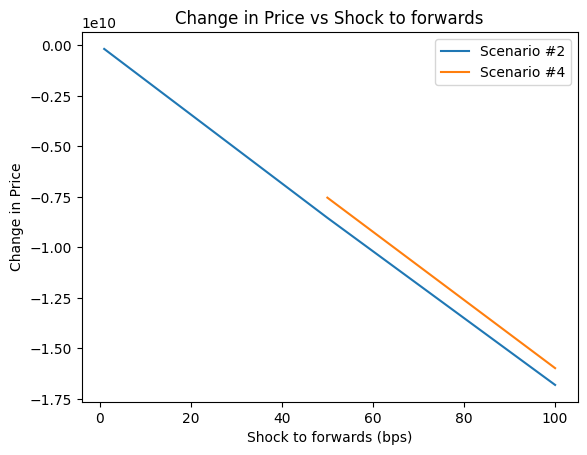

In [56]:
import matplotlib.pyplot as plt

# Assuming shocks and corresponding PV changes are stored in lists
shocks = [1, 50, 100]  # shocks to forwards
pv_changes_2 = [PV01, PV50, PV100]  # PV changes for scenario #2
pv_changes_4 = [np.nan, PV50_part2, PV100_part2]  # PV changes for scenario #4

plt.plot(shocks, pv_changes_2, label='Scenario #2')
plt.plot(shocks, pv_changes_4, label='Scenario #4')

plt.xlabel('Shock to forwards (bps)')
plt.ylabel('Change in Price')
plt.title('Change in Price vs Shock to forwards')
plt.legend()
plt.show()

<Axes: title={'center': 'PV Changes for P2 and P4'}>

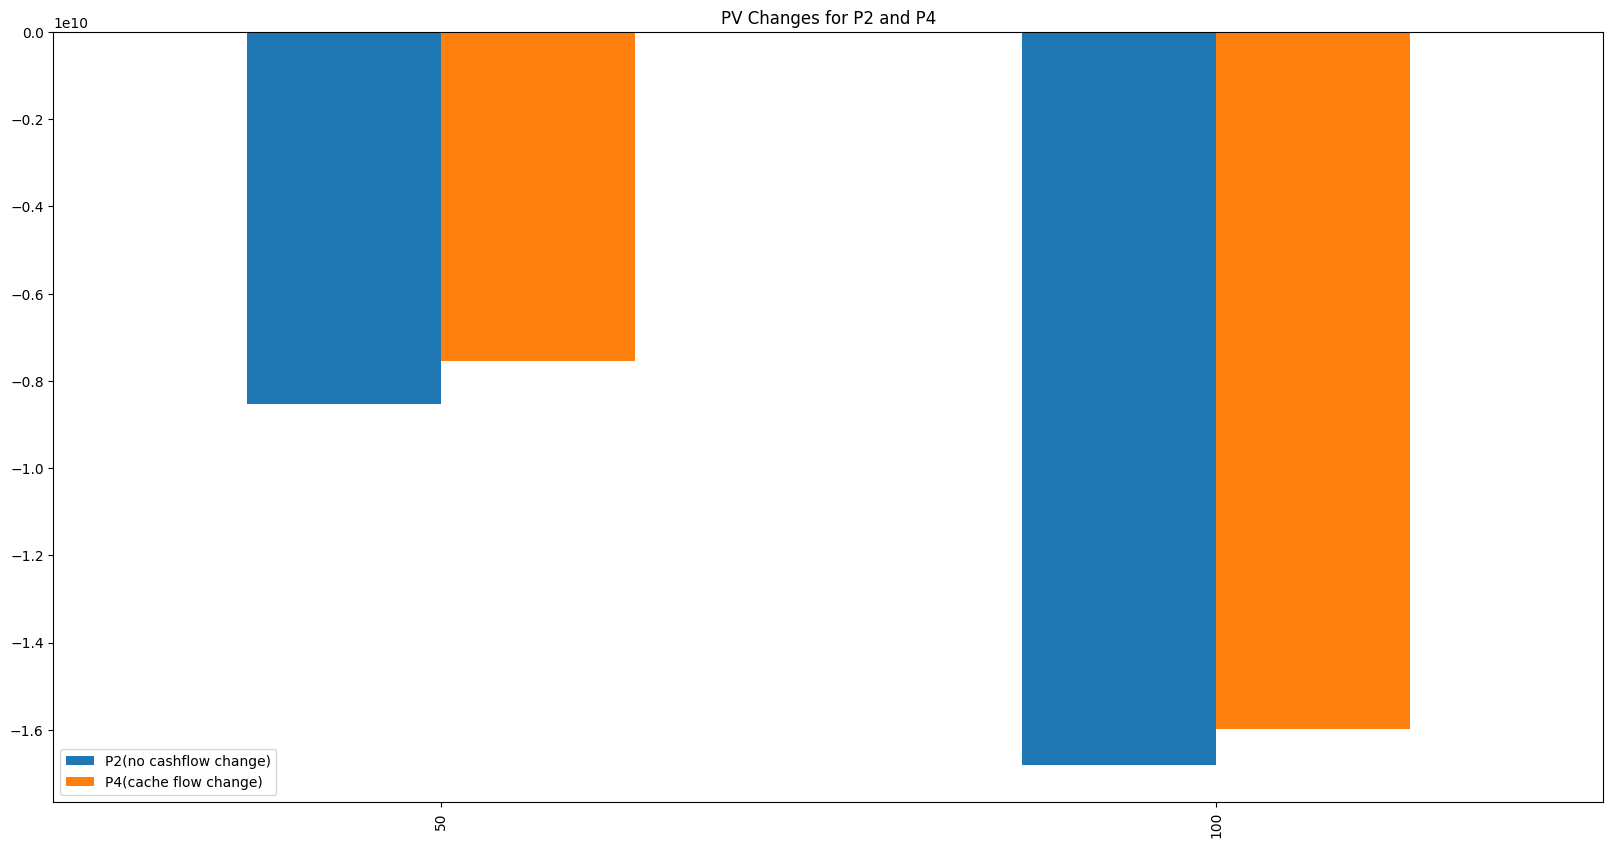

In [58]:
plot_result = pd.DataFrame(
    {
        '50': [PV50, PV50_part2],
        '100': [PV100, PV100_part2]
    },
    index = ['P2(no cashflow change)', 'P4(cache flow change)']
)

plot_result.T.plot(kind='bar', figsize=(20, 10), title='PV Changes for P2 and P4')

# Explanation

P4 where cashflow has change will have a smaller change in price compared to P2 where cashflow does not change. This is because when interest rate rise, based on our S-curve model the CPR will decrease which will lead to a decrease in prepayments. This will lead to increase in the coupon amount which will offset the decrease in the price of the MBS due to the increase in interest rates.

